In [98]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchsummary import summary
from torch.cuda.amp import autocast, GradScaler

import numpy as np
import pandas as pd
import gzip
import pickle
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gc
import time
import random
import matplotlib.pyplot as plt


import sys
sys.path.append('..')
# from slp_package.slp_functions import create_merged_game_data_df
from slp_package.input_dataset import InputDataSet
import slp_package.pytorch_functions as slp_pytorch_functions

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using CUDA
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [99]:
path = "/workspace/melee_project_data/input_np/mango/FALCO/72a00ff5-b2a2-4afa-9b63-9523feaf9beb.npy.gz"

with gzip.open(path, 'rb') as f:
            segment = np.load(f)

for n in range(5,9):
    print(np.unique(segment[n,:]))
    
non_zero = segment[0] != 0
print(np.min(np.abs(segment[0,non_zero])))

[0.]
[0. 1.]
[0. 1.]
[0. 1.]
0.2875


In [100]:
path = "/workspace/melee_project_data/input_np/mango/FALCO/72a00ff5-b2a2-4afa-9b63-9523feaf9beb.npy.gz"

with gzip.open(path, 'rb') as f:
            segment = np.load(f)

for n in range(5,9):
    print(np.unique(segment[n,:]))
    print('ones:', np.sum(segment[n,:]), ', zeros:', segment.shape[1] - np.sum(segment[n,:]))

# print(segment)

[0.]
ones: 0.0 , zeros: 10604.0
[0. 1.]
ones: 1023.0 , zeros: 9581.0
[0. 1.]
ones: 944.0 , zeros: 9660.0
[0. 1.]
ones: 1731.0 , zeros: 8873.0


In [101]:
path = "/workspace/melee_project_data/input_np/mango/FALCO/e55c959c-533d-4b0e-82b1-4e79decd25e2.npy.gz"

with gzip.open(path, 'rb') as f:
            segment = np.load(f)

for n in range(5,9):
    print(np.unique(segment[n,:]))
    print('ones:', np.sum(segment[n,:]), ', zeros:', segment.shape[1] - np.sum(segment[n,:]))




[0. 1.]
ones: 56.0 , zeros: 18805.0
[0. 1.]
ones: 1706.0 , zeros: 17155.0
[0. 1.]
ones: 1644.0 , zeros: 17217.0
[0. 1.]
ones: 3769.0 , zeros: 15092.0


In [102]:
source_data = ['ranked','public','mango']

general_features = {
    'stage_name': ['FOUNTAIN_OF_DREAMS','FINAL_DESTINATION','BATTLEFIELD','YOSHIS_STORY','POKEMON_STADIUM','DREAMLAND'],
    'num_players': [2],
    'conclusive': [True],
}
player_features = {
    # 'netplay_code': ['MANG#0'],
    'character_name': ['YOSHI'],
    # 'character_name': ['FOX', 'FALCO', 'MARTH', 'CAPTAIN_FALCON', 'SHEIK'],
    # 'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'MARIO', 'PEACH', 'ROY', 'LUIGI', 'YOUNG_LINK', 'DONKEY_KONG', 'PICHU', 'KIRBY'],
    # 'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'PEACH', 'LUIGI', 'DONKEY_KONG'],
    'type_name': ['HUMAN']
    
}
opposing_player_features = {
    # 'character_name': ['MARTH'],
    # 'netplay_code': ['KOD#0', 'ZAIN#0']
    'type_name': ['HUMAN']
}
label_info = {
    'source': ['player'], # Can be 'general', 'player
    # 'feature': ['netplay_code']
    'feature': ['character_name']
}

In [103]:
dataset = InputDataSet(source_data, general_features, player_features, opposing_player_features, label_info)

df = dataset.dataset

df.head()

/workspace/slp_jaspar/extract_all_data/../slp_package/input_dataset.py:95: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  processed_df = pd.concat([player_1_df, player_2_df], ignore_index=True)


,stage_name,num_players,conclusive,player_character_name,player_type_name,opposing_player_type_name,player_inputs_np_sub_path,length,labels
0,BATTLEFIELD,2,True,YOSHI,HUMAN,HUMAN,mango\YOSHI\9357ebde-ad9d-42b7-a9c5-0f711bb224...,7628,YOSHI
1,BATTLEFIELD,2,True,YOSHI,HUMAN,HUMAN,mango\YOSHI\d303b15c-8e08-42c5-8436-fd82b3c4eb...,11515,YOSHI
2,POKEMON_STADIUM,2,True,YOSHI,HUMAN,HUMAN,mango\YOSHI\3f653563-b1c2-4a54-948b-8d6c2fbfcf...,9223,YOSHI
3,FINAL_DESTINATION,2,True,YOSHI,HUMAN,HUMAN,mango\YOSHI\c59c0e0f-a90b-4989-ad8f-f48fc9c089...,10474,YOSHI
4,FOUNTAIN_OF_DREAMS,2,True,YOSHI,HUMAN,HUMAN,mango\YOSHI\db678e2c-68b2-45d2-87ca-b4a28ab799...,10884,YOSHI


In [104]:
sample_df = df.sample(n=1000, random_state=42)
print(sample_df.shape)
print(sample_df.describe())
sample_df.head()

(1000, 9)
       num_players        length
count       1000.0   1000.000000
mean           2.0  10763.339000
std            0.0   3045.371952
min            2.0   1575.000000
25%            2.0   8653.750000
50%            2.0  10575.000000
75%            2.0  12435.250000
max            2.0  26162.000000


,stage_name,num_players,conclusive,player_character_name,player_type_name,opposing_player_type_name,player_inputs_np_sub_path,length,labels
3426,YOSHIS_STORY,2,True,YOSHI,HUMAN,HUMAN,ranked\YOSHI\7b5f4304-9c3c-4e5e-8c51-f6b6ddb27...,7268,YOSHI
2846,FOUNTAIN_OF_DREAMS,2,True,YOSHI,HUMAN,HUMAN,public\YOSHI\ec8a6431-5250-4c83-9561-45b31b44b...,12238,YOSHI
5160,BATTLEFIELD,2,True,YOSHI,HUMAN,HUMAN,public\YOSHI\516f1f4f-a218-4990-8def-0ebd882af...,13070,YOSHI
622,BATTLEFIELD,2,True,YOSHI,HUMAN,HUMAN,ranked\YOSHI\249ab694-5682-4b87-96e3-2050f640b...,14568,YOSHI
4819,BATTLEFIELD,2,True,YOSHI,HUMAN,HUMAN,ranked\YOSHI\5768905e-1a84-485f-9799-21762c149...,12364,YOSHI


In [105]:
data_key = { 
    'JSTICK_X':[],
    'JSTICK_Y':[], 
    'CSTICK_X':[], 
    'CSTICK_Y':[],  
    'TRIGGER_LOGICAL':[],  
    'Z':[],  
    'A':[],  
    'B':[], 
    'X_or_Y':[]
}

def load_and_process(path, length, row_sums_dict):
    
    with gzip.open(path, 'rb') as f:
            inputs = np.load(f)
    
    
    # Want a new dictionary with each the sum of each row of inputs being added the values of data_key
    row_sums_np = np.sum(np.abs(inputs), axis=1) / length
    # Map each sum to the corresponding key in data_key
    keys = row_sums_dict.keys()
    for index, key in enumerate(keys):
        row_sums_dict[key].append(row_sums_np[index])
    
    row_sums_dict.update(row_sums_dict)
    return 

row_sums_dict = data_key.copy()
for i in range(sample_df.shape[0]):
# for i in range(3):
    load_and_process('/workspace/melee_project_data/input_np/' + sample_df['player_inputs_np_sub_path'].iloc[i].replace('\\','/'),sample_df['length'].iloc[i],row_sums_dict)

row_sums_df = pd.DataFrame(row_sums_dict)
# print(row_sums_df.head())
row_sums_df.describe()
    
    

,JSTICK_X,JSTICK_Y,CSTICK_X,CSTICK_Y,TRIGGER_LOGICAL,Z,A,B,X_or_Y
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.480759,0.236106,0.019392,0.016251,0.153829,0.004922,0.081723,0.020862,0.151547
std,0.050180,0.039577,0.012423,0.012173,0.035024,0.008954,0.028632,0.013055,0.032763
min,0.245571,0.092758,0.000000,0.000296,0.035895,0.000000,0.017484,0.000000,0.002241
25%,0.453888,0.214731,0.010781,0.009138,0.129610,0.000000,0.058792,0.011855,0.136201
50%,0.483590,0.238381,0.016221,0.013048,0.154036,0.001232,0.083249,0.018452,0.154657
75%,0.511068,0.260279,0.025644,0.019696,0.178980,0.005856,0.101902,0.026830,0.171921
max,0.630175,0.495935,0.086568,0.099738,0.265158,0.088232,0.170161,0.110387,0.279289


In [106]:
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define input keys
input_keys = ['JSTICK_X', 'JSTICK_Y', 'CSTICK_X', 'CSTICK_Y', 'TRIGGER_LOGICAL', 'Z', 'A', 'B', 'X_or_Y']
binary_keys = ['TRIGGER_LOGICAL', 'Z', 'A', 'B', 'X_or_Y']

# Initialize global histograms with appropriate bin edges
bin_edges = {
    key: np.linspace(-1, 1, 21) if key not in binary_keys else np.array([0, 1, 2])
    for key in input_keys
}
global_histograms = {key: np.zeros(len(bin_edges[key]) - 1) for key in input_keys}

def load_and_process(path, length, histograms):
    with gzip.open(path, 'rb') as f:
        inputs = np.load(f)

    # Ensure inputs have the correct number of columns
    if inputs.shape[0] != len(input_keys):
        raise ValueError(f"Expected number of columns: {len(input_keys)}, but got {inputs.shape[0]}")

    # Compute histograms for each column
    for index, key in enumerate(input_keys):
        row_histogram, _ = np.histogram(inputs[index,:], bins=bin_edges[key])
        histograms[key] += row_histogram / length

# # Example DataFrame loading and processing loop
# # sample_df = pd.read_csv('path_to_your_dataframe.csv')
# for i in range(sample_df.shape[0]):
#     path = '/workspace/melee_project_data/input_np/' + sample_df['player_inputs_np_sub_path'].iloc[i].replace('\\', '/')
#     load_and_process(path, sample_df['length'].iloc[i], global_histograms)

# # Display histograms
# for key, counts in global_histograms.items():
#     plt.figure(figsize=(10,5))
#     plt.title(f'Histogram for {key}')
#     plt.bar(range(len(counts)), counts / sample_df.shape[0], tick_label=bin_edges[key][:-1])
#     plt.xlabel('Bins')
#     plt.ylabel('Counts')
#     plt.show()


In [107]:

print(sample_df.shape)
print(sample_df.describe())
sample_df.head()

(1000, 9)
       num_players        length
count       1000.0   1000.000000
mean           2.0  10763.339000
std            0.0   3045.371952
min            2.0   1575.000000
25%            2.0   8653.750000
50%            2.0  10575.000000
75%            2.0  12435.250000
max            2.0  26162.000000


,stage_name,num_players,conclusive,player_character_name,player_type_name,opposing_player_type_name,player_inputs_np_sub_path,length,labels
3426,YOSHIS_STORY,2,True,YOSHI,HUMAN,HUMAN,ranked\YOSHI\7b5f4304-9c3c-4e5e-8c51-f6b6ddb27...,7268,YOSHI
2846,FOUNTAIN_OF_DREAMS,2,True,YOSHI,HUMAN,HUMAN,public\YOSHI\ec8a6431-5250-4c83-9561-45b31b44b...,12238,YOSHI
5160,BATTLEFIELD,2,True,YOSHI,HUMAN,HUMAN,public\YOSHI\516f1f4f-a218-4990-8def-0ebd882af...,13070,YOSHI
622,BATTLEFIELD,2,True,YOSHI,HUMAN,HUMAN,ranked\YOSHI\249ab694-5682-4b87-96e3-2050f640b...,14568,YOSHI
4819,BATTLEFIELD,2,True,YOSHI,HUMAN,HUMAN,ranked\YOSHI\5768905e-1a84-485f-9799-21762c149...,12364,YOSHI


The vast majority of stick inputs are 0, followed by up, down, left, right. around the perimeter and the axes


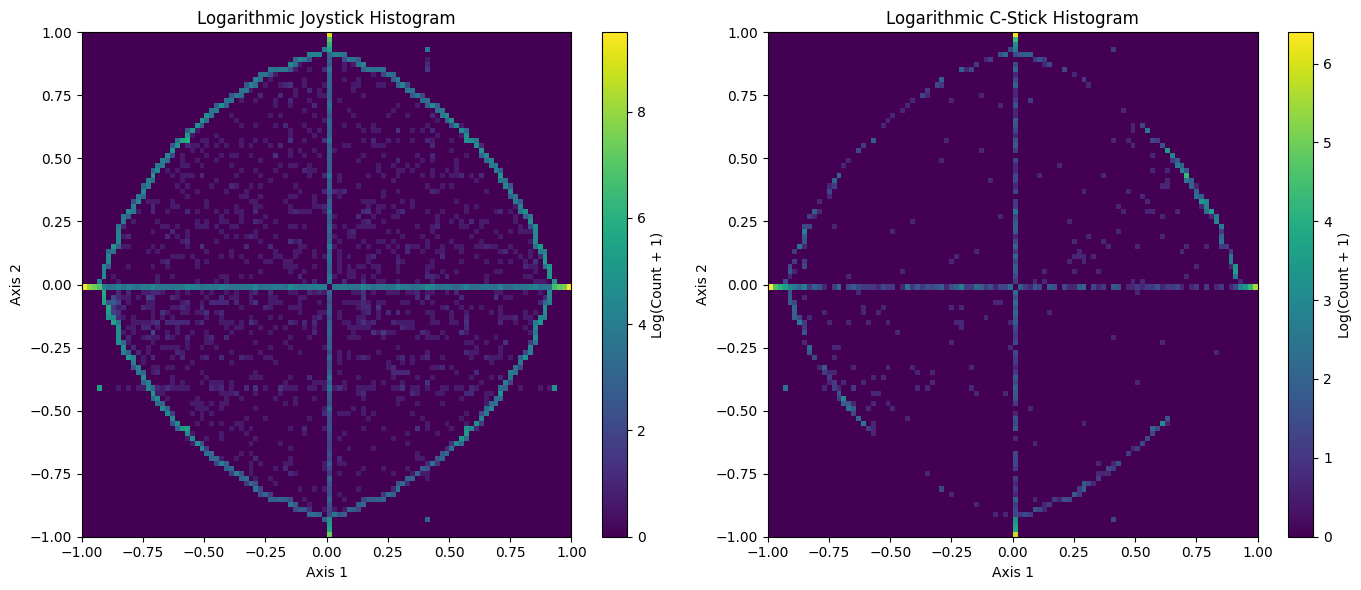

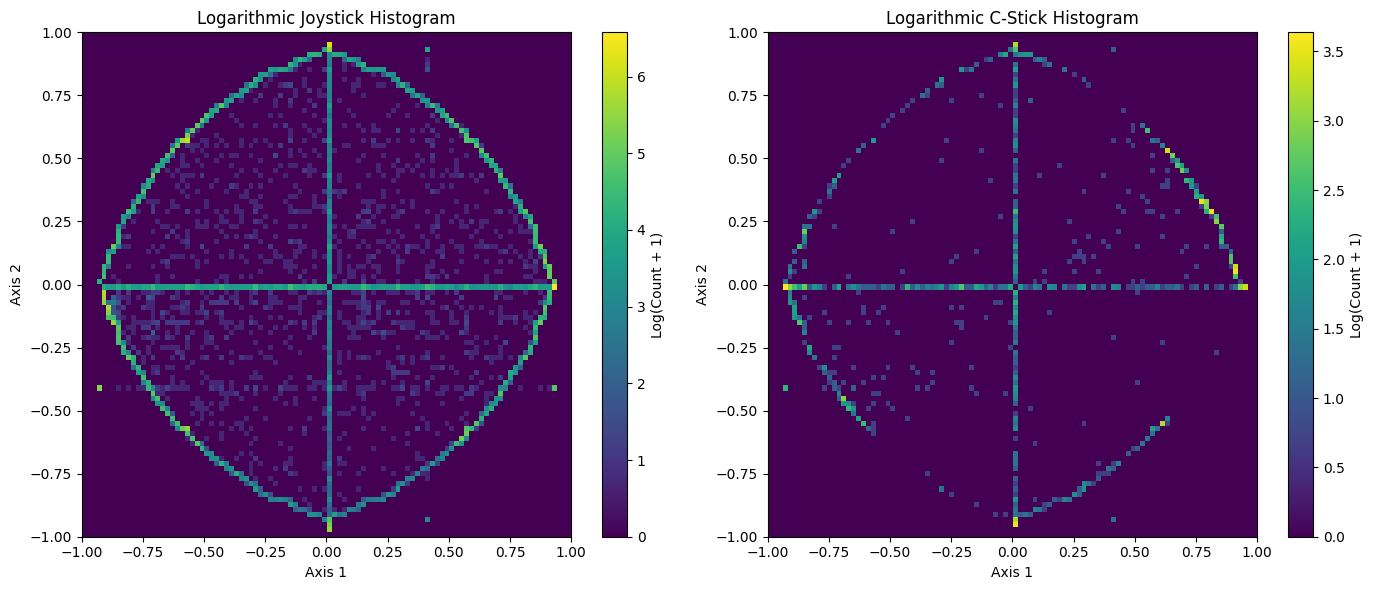

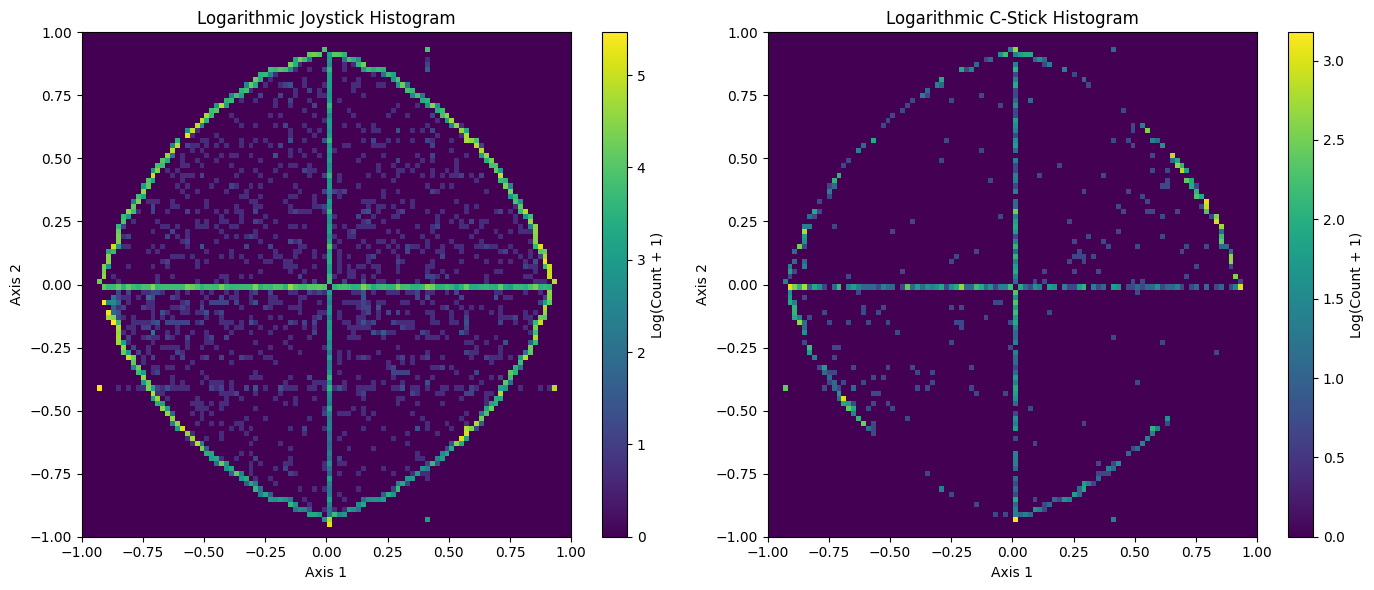

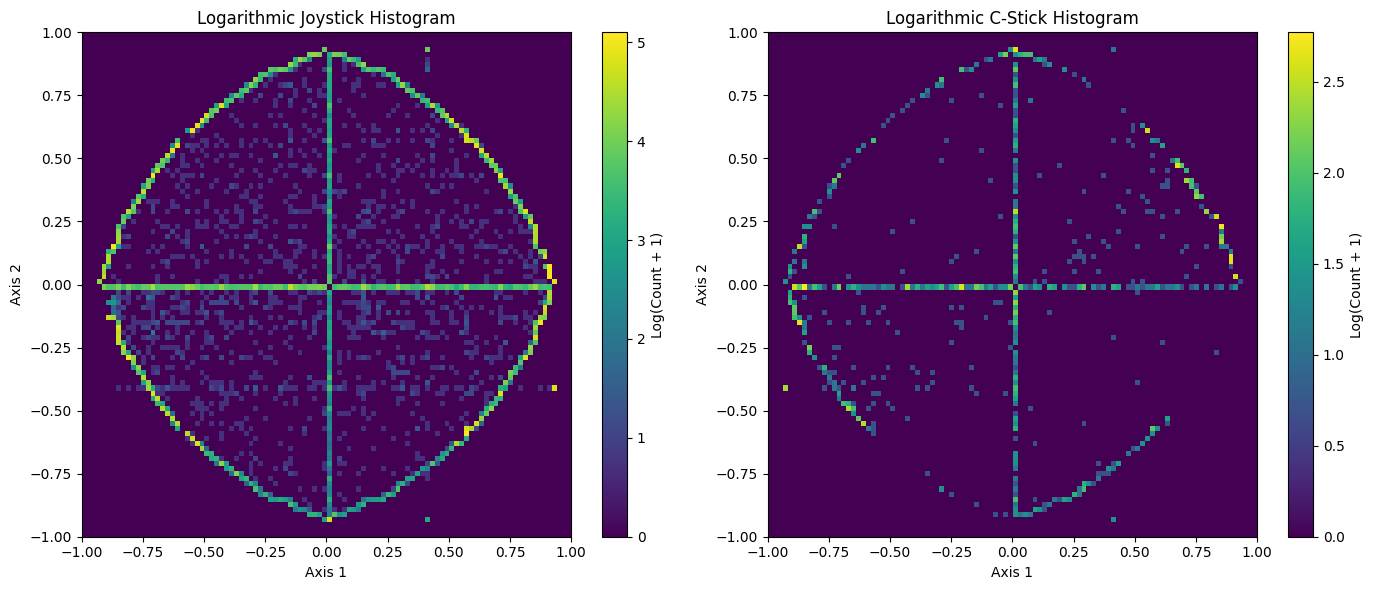

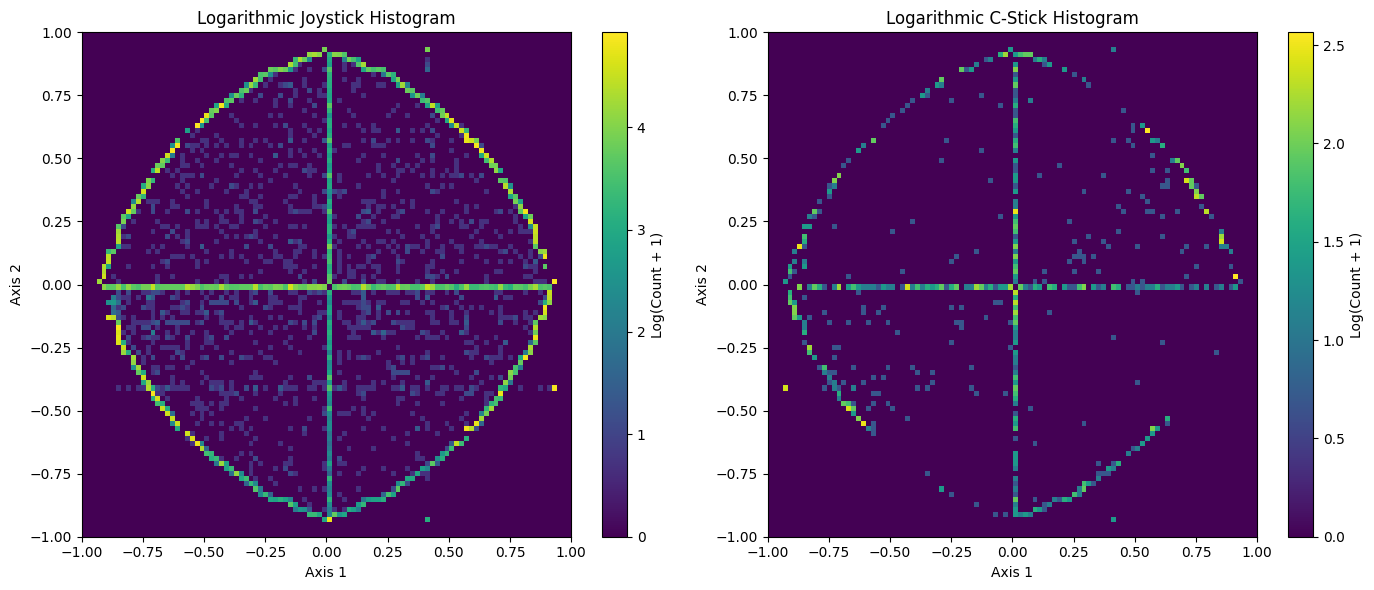

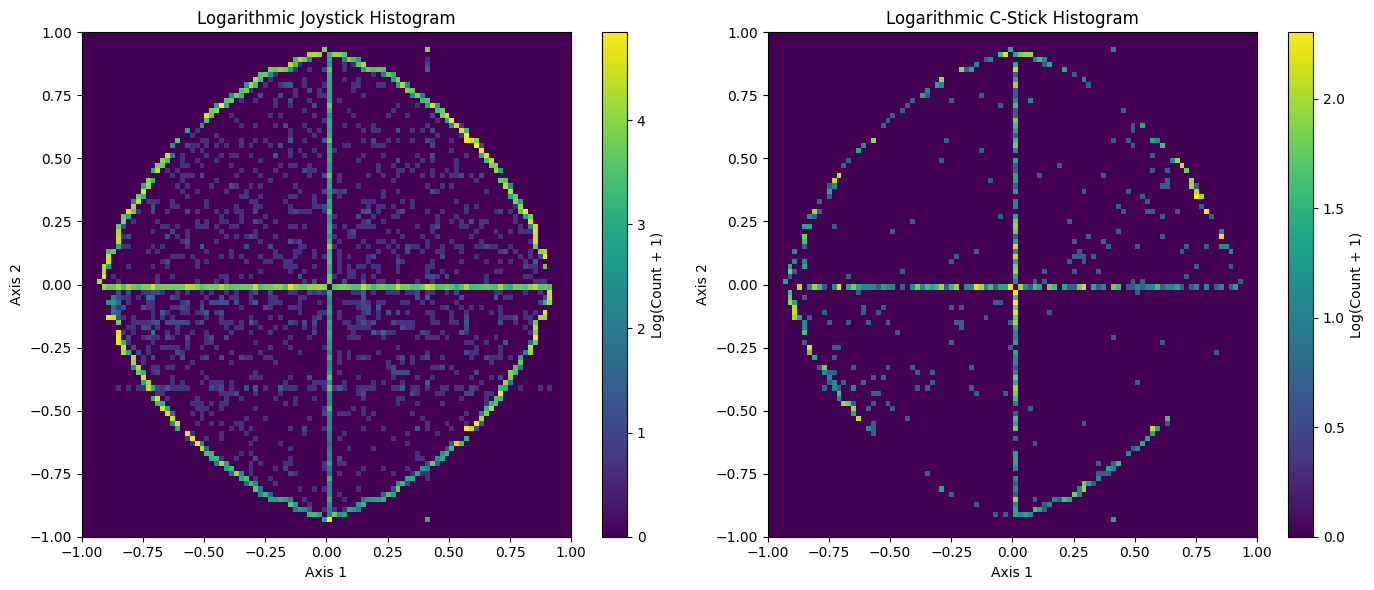

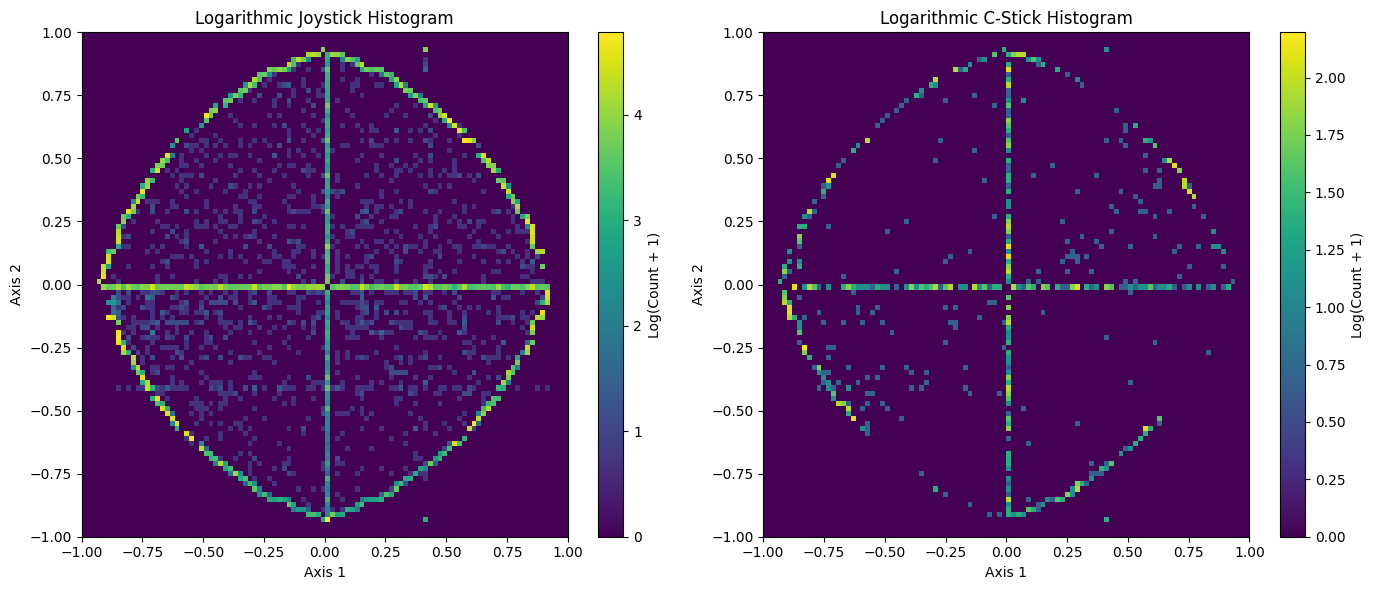

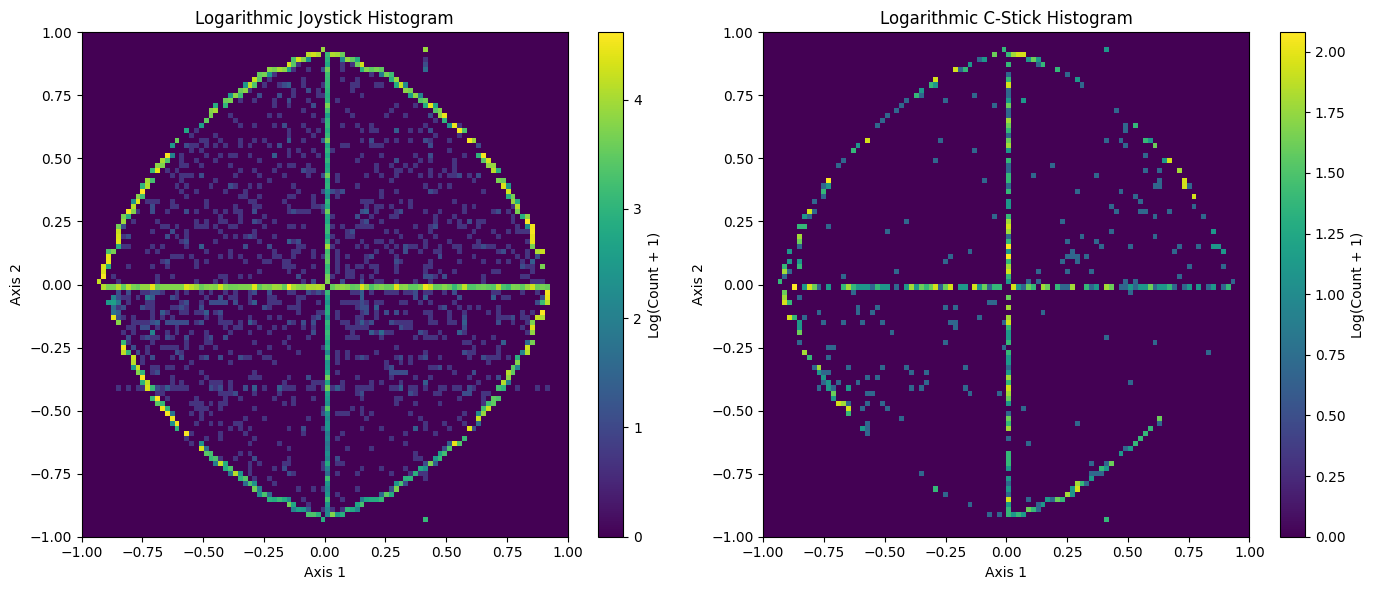

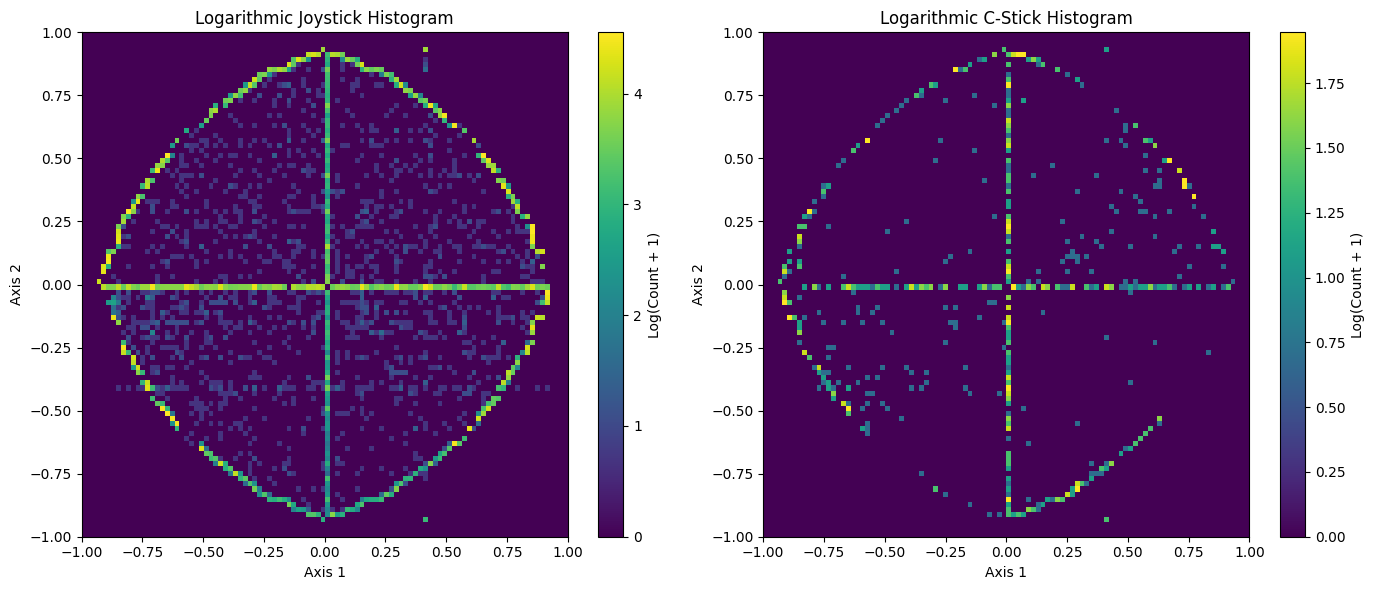

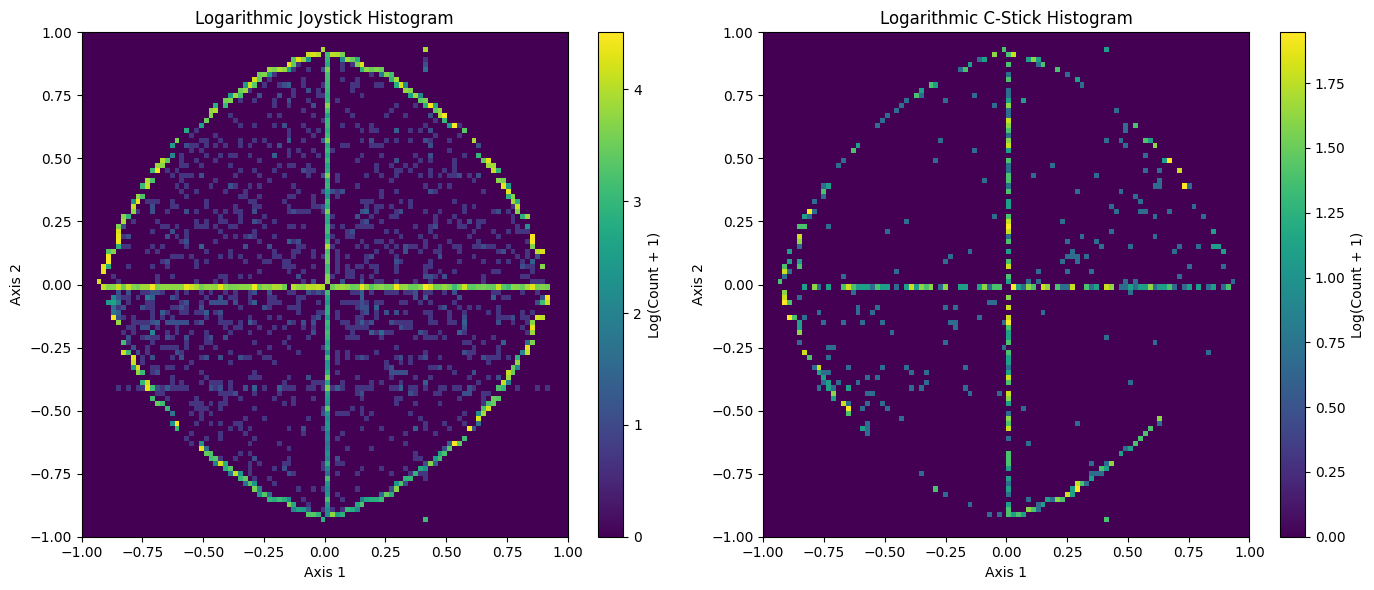

In [108]:


def load_and_update_histogram(path, jstick_histogram, cstick_histogram, nbins):
    with gzip.open(path, 'rb') as f:
        inputs = np.load(f)
    
    # Correcting the shift and scaling logic
    # Shift inputs: adjusting so that positives are reduced and negatives are increased
    inputs[0:4, :] -= .2875 * (inputs[0:4, :] > 0)
    inputs[0:4, :] += .2875 * (inputs[0:4, :] < 0)

    # Scale inputs to be between -1 and 1
    inputs[0:4, :] *= 1.40350877193

    # Update histograms
    j_hist, _, _ = np.histogram2d(inputs[1, :], inputs[0, :], bins=nbins, range=[(-1, 1), (-1, 1)])
    c_hist, _, _ = np.histogram2d(inputs[3, :], inputs[2, :], bins=nbins, range=[(-1, 1), (-1, 1)])
    
    jstick_histogram += j_hist
    cstick_histogram += c_hist

# Sample initialization and usage
sample_df = df.sample(n=1000, random_state=42)
nbins = 100
jstick_histogram = np.zeros((nbins, nbins), dtype=np.float64)
cstick_histogram = np.zeros((nbins, nbins), dtype=np.float64)

# Assuming 'paths' is a list of file paths to process
for i in range(10):
    path = '/workspace/melee_project_data/input_np/' + sample_df['player_inputs_np_sub_path'].iloc[i].replace('\\', '/')
    load_and_update_histogram(path, jstick_histogram, cstick_histogram, nbins)


def remove_populous_bins(histogram, n):
    # Flatten the histogram to work with 1D array of bins
    flat_histogram = histogram.flatten()
    
    # Find the indices of the n most populous bins
    indices_to_remove = np.argpartition(flat_histogram, -n)[-n:]
    
    # Set these bins' values to zero or minimal value
    flat_histogram[indices_to_remove] = 0
    # Optionally, set to the minimal non-zero value found in original histogram
    # min_value = np.min(flat_histogram[np.nonzero(flat_histogram)])
    # flat_histogram[indices_to_remove] = min_value

    # Reshape back to the original histogram shape
    return flat_histogram.reshape(histogram.shape)


def plot_log_histograms(jstick_histogram, cstick_histogram, nbins, n_remove):
    # Remove the n most populous bins
    jstick_histogram = remove_populous_bins(jstick_histogram, n_remove)
    cstick_histogram = remove_populous_bins(cstick_histogram, n_remove)
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Prepare data for logarithmic scale
    log_jstick_histogram = jstick_histogram
    log_cstick_histogram = cstick_histogram
    log_jstick_histogram = np.log(jstick_histogram + 1)  # Add 1 to avoid log(0)
    log_cstick_histogram = np.log(cstick_histogram + 1)  # Add 1 to avoid log(0)

    # Joystick histogram
    im = axs[0].imshow(log_jstick_histogram, interpolation='nearest', origin='upper',
                        extent=[-1, 1, -1, 1], aspect='auto', cmap='viridis')
    axs[0].set_title('Logarithmic Joystick Histogram')
    axs[0].set_xlabel('Axis 1')
    axs[0].set_ylabel('Axis 2')
    plt.colorbar(im, ax=axs[0], label='Log(Count + 1)')

    # C-stick histogram
    im = axs[1].imshow(log_cstick_histogram, interpolation='nearest', origin='upper',
                        extent=[-1, 1, -1, 1], aspect='auto', cmap='viridis')
    axs[1].set_title('Logarithmic C-Stick Histogram')
    axs[1].set_xlabel('Axis 1')
    axs[1].set_ylabel('Axis 2')
    plt.colorbar(im, ax=axs[1], label='Log(Count + 1)')

    plt.tight_layout()
    plt.show()

# Assuming your histograms are ready
nbins = 100
n_remove = 10 # Number of populous bins to remove
# Assuming your histograms are ready
nbins = 100
n_remove = 10 # Number of populous bins to remove

for n in range(0,10):
    plot_log_histograms(jstick_histogram, cstick_histogram, nbins, n * n_remove + 1)


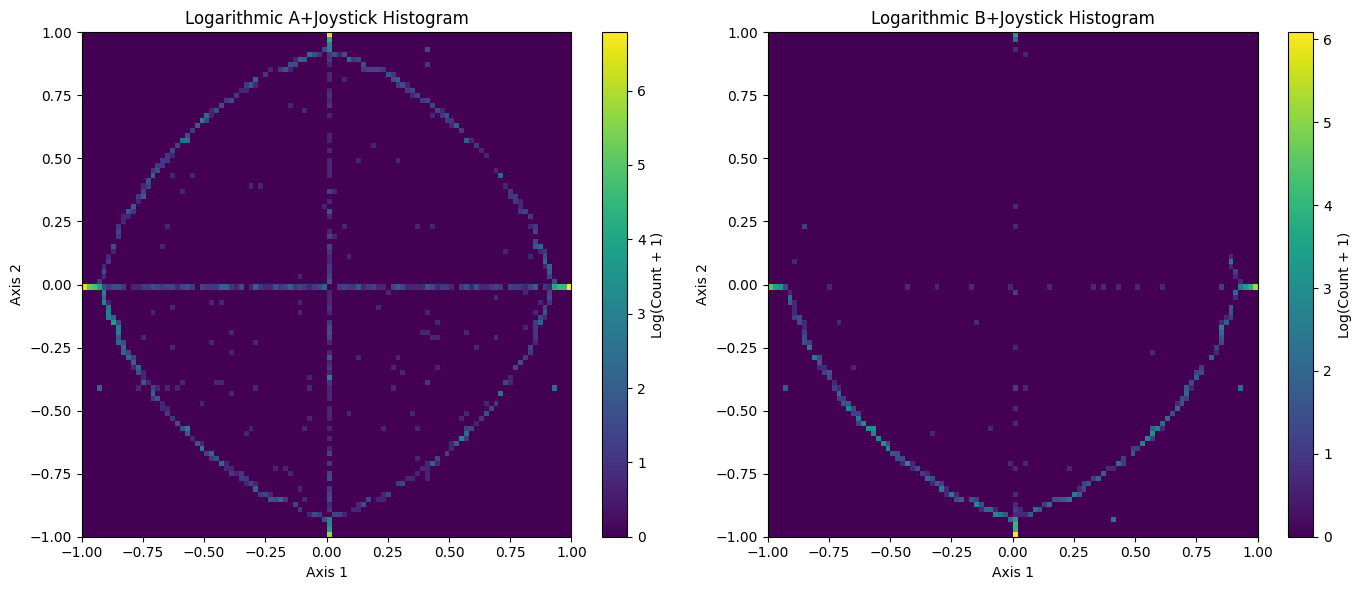

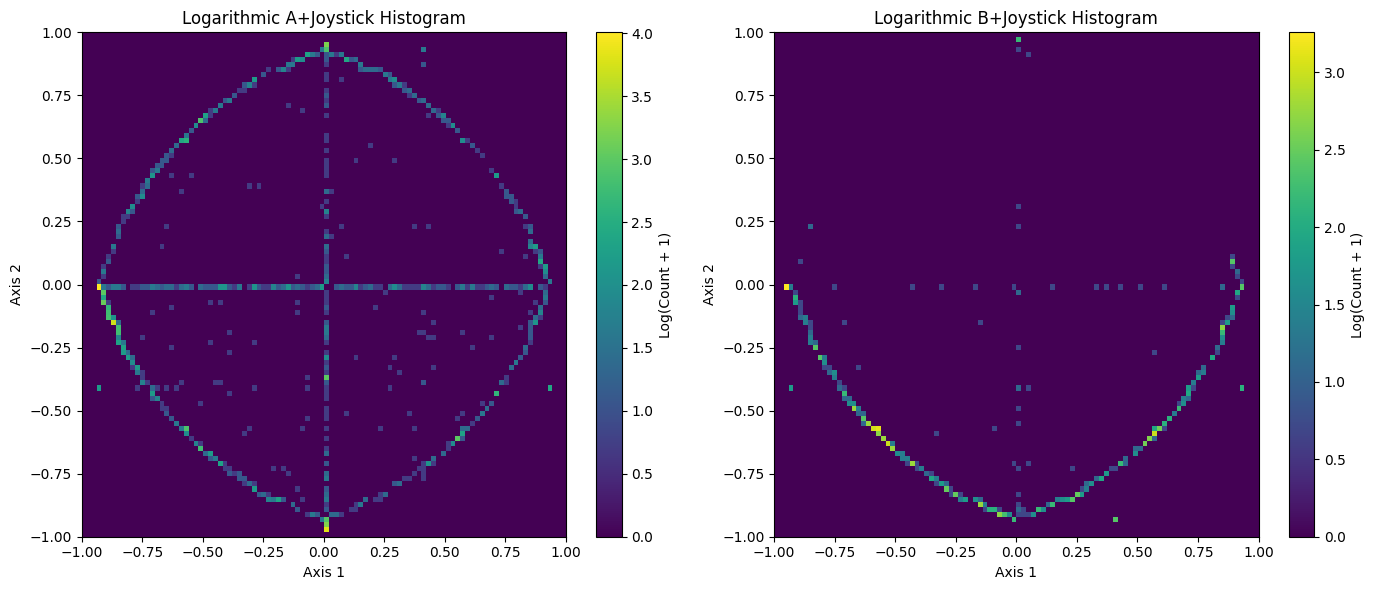

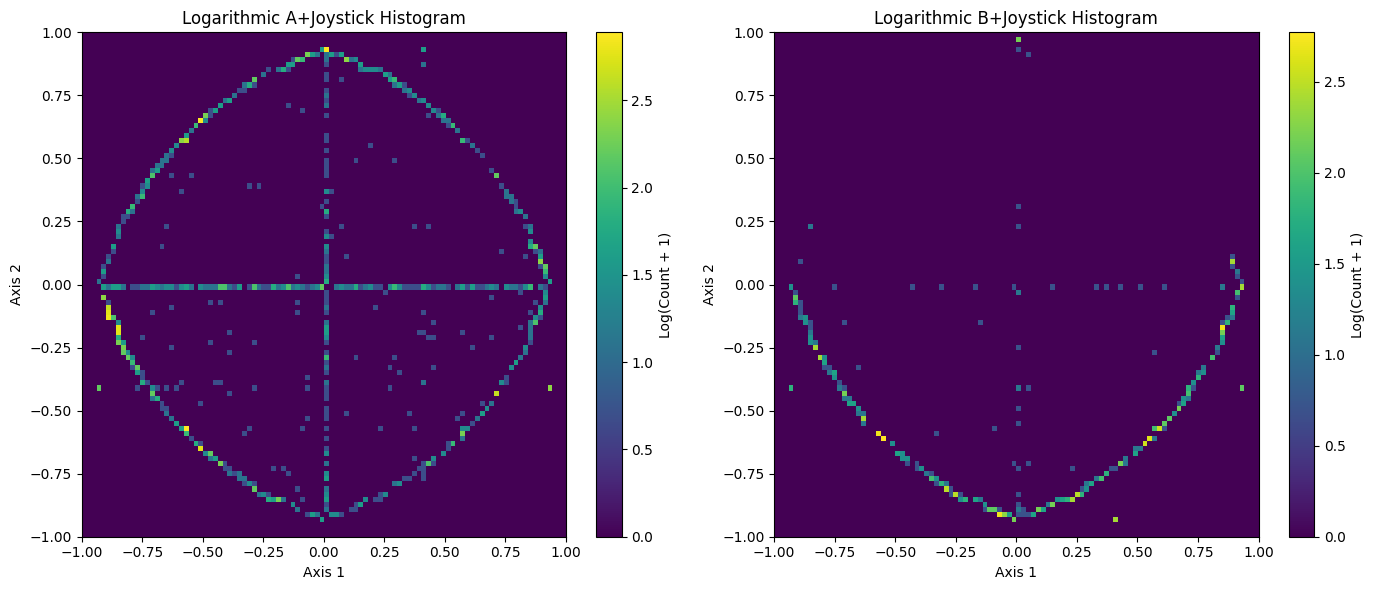

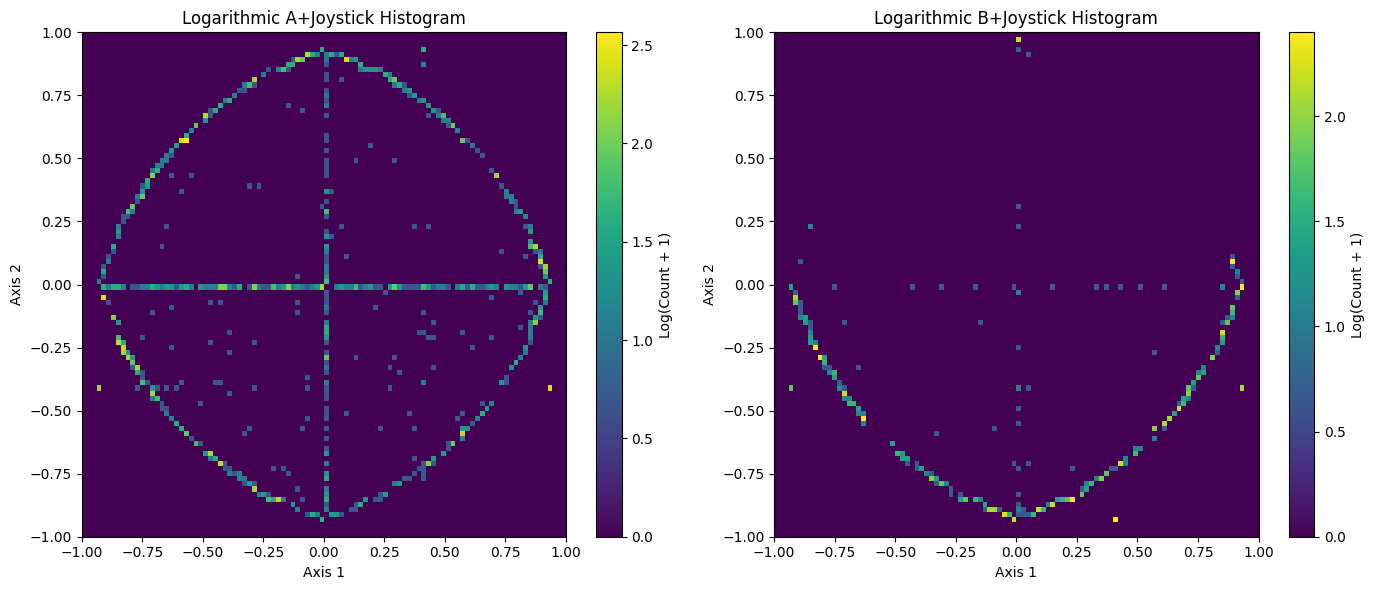

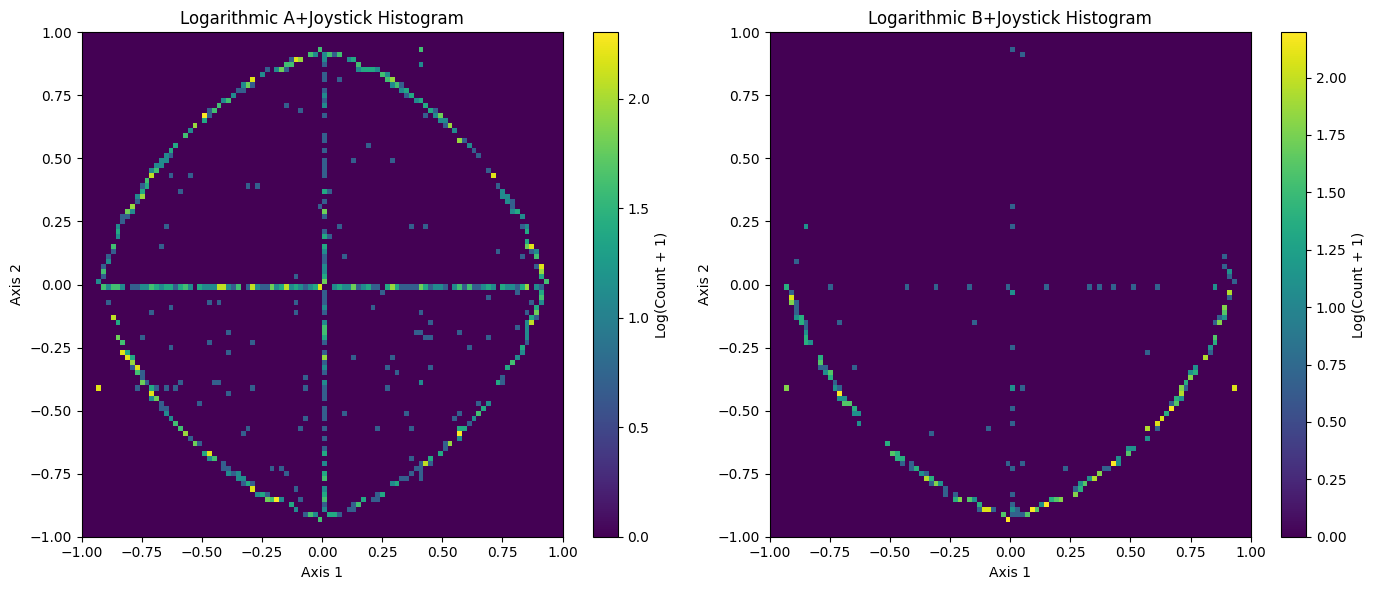

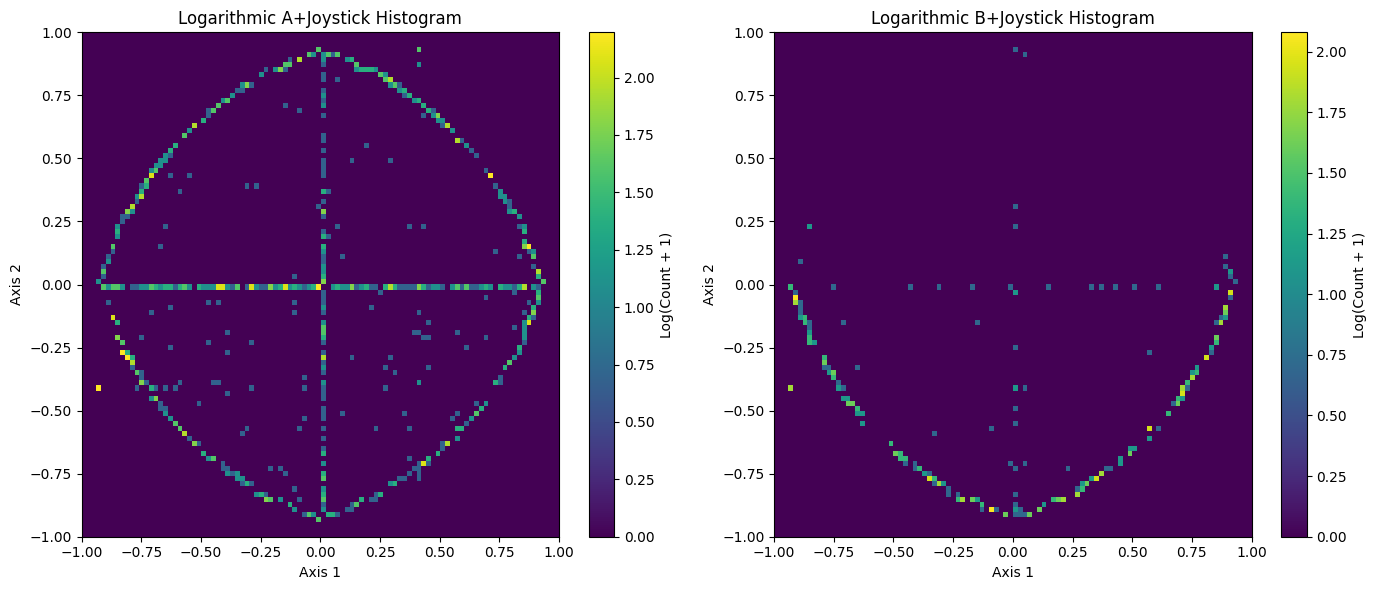

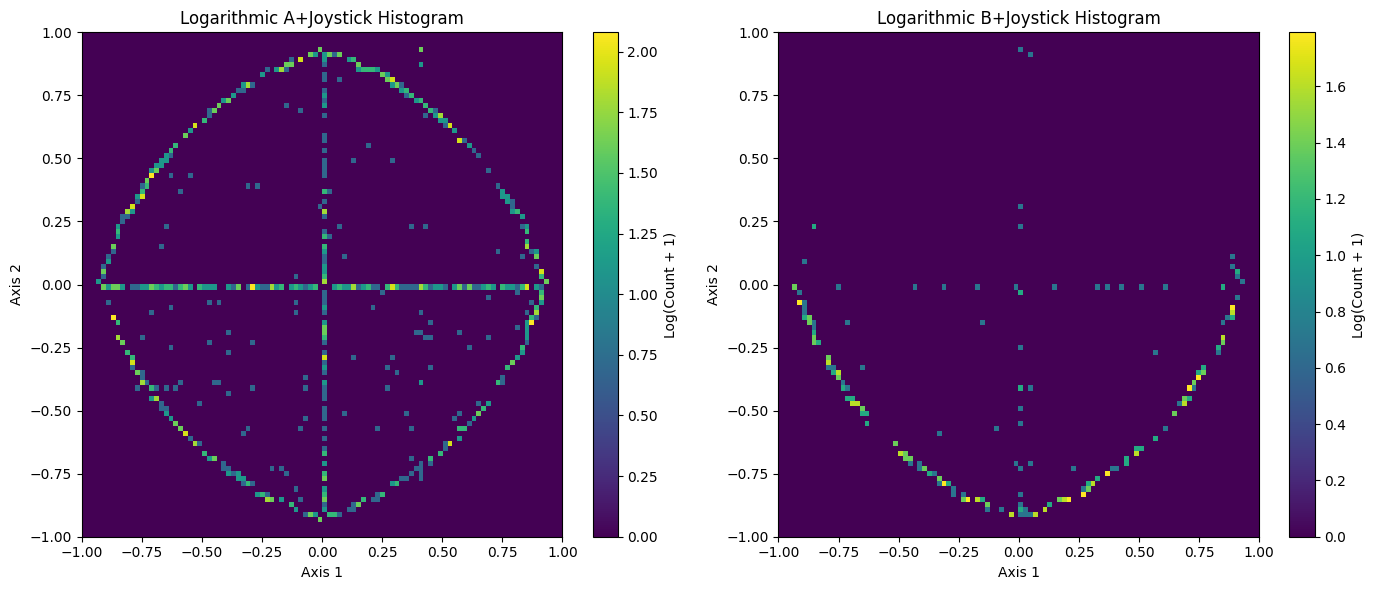

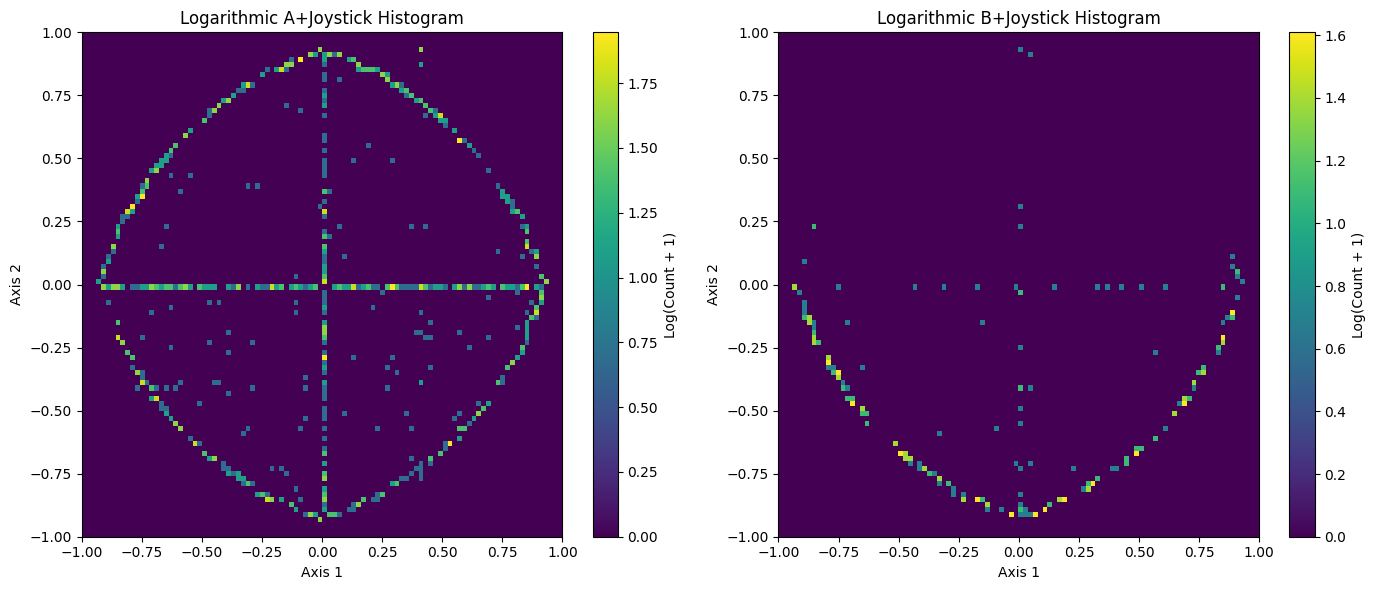

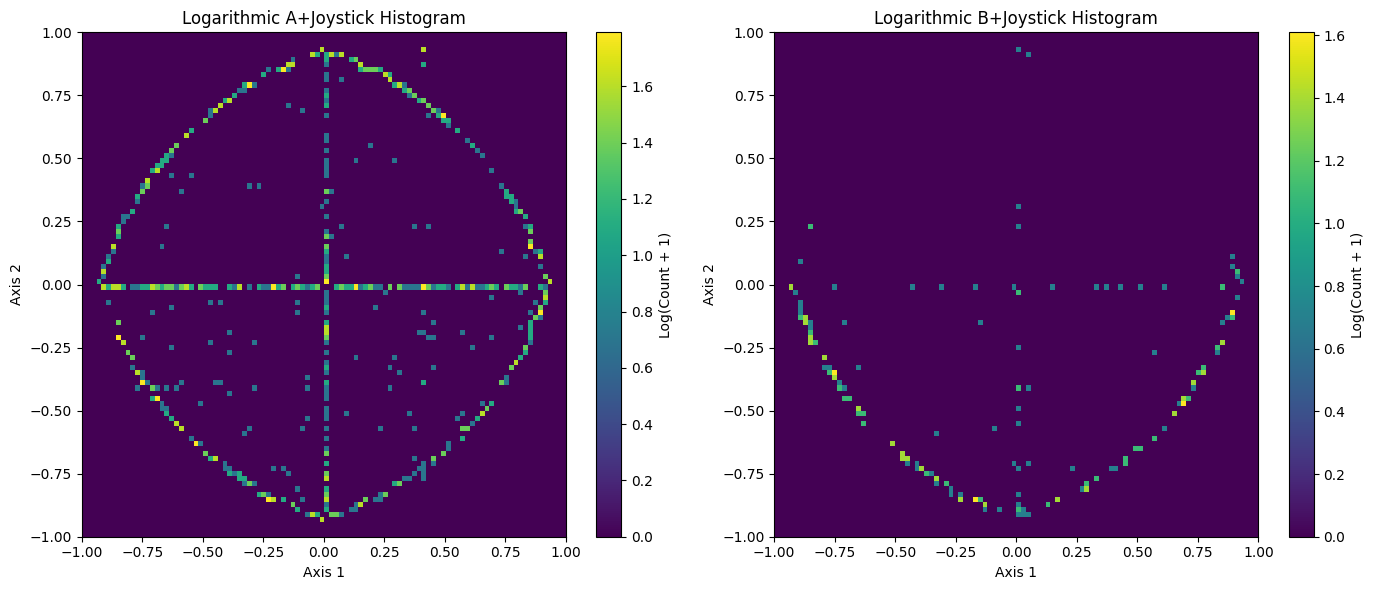

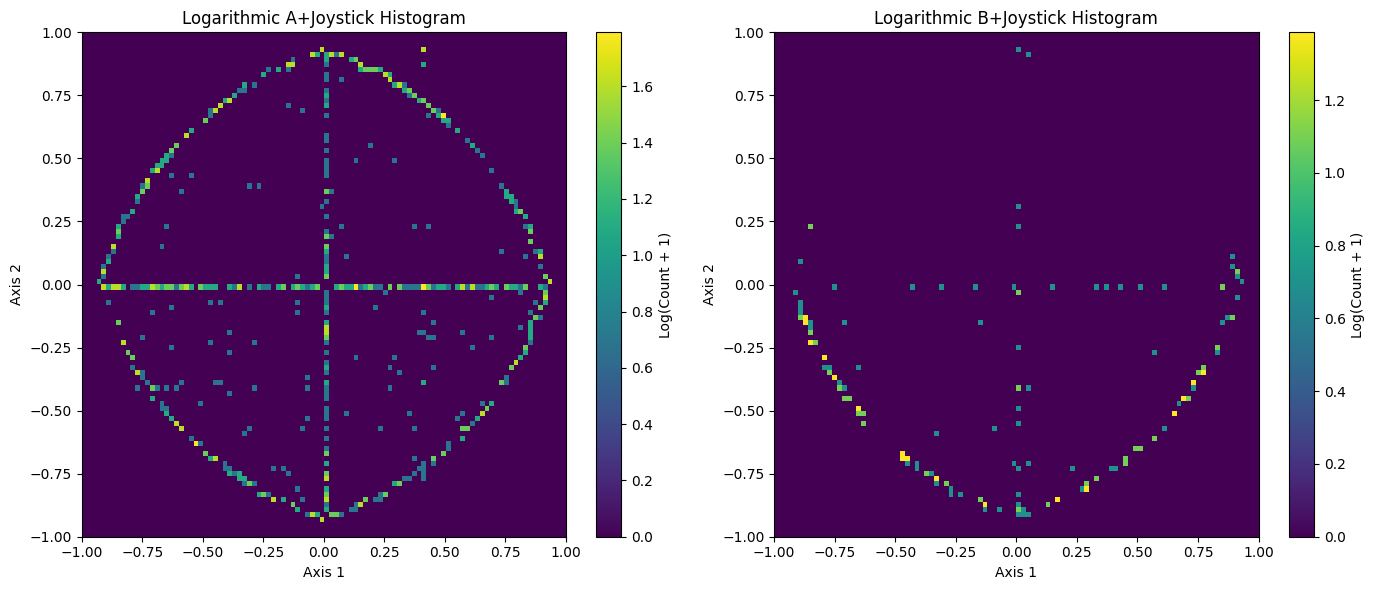

In [110]:


def load_and_update_histogram(path, jstick_histogram, cstick_histogram, nbins):
    with gzip.open(path, 'rb') as f:
        inputs = np.load(f)
    
    # Correcting the shift and scaling logic
    # Shift inputs: adjusting so that positives are reduced and negatives are increased
    inputs[0:4, :] -= .2875 * (inputs[0:4, :] > 0) 
    inputs[0:4, :] += .2875 * (inputs[0:4, :] < 0)

    # Scale inputs to be between -1 and 1
    inputs[0:4, :] *= 1.40350877193

    # Update histograms
    j_hist, _, _ = np.histogram2d(inputs[1, :] * inputs[-3,:], inputs[0, :] * inputs[-3,:], bins=nbins, range=[(-1, 1), (-1, 1)])
    c_hist, _, _ = np.histogram2d(inputs[1, :] * inputs[-2,:], inputs[0, :] * inputs[-2,:], bins=nbins, range=[(-1, 1), (-1, 1)])
    
    jstick_histogram += j_hist
    cstick_histogram += c_hist

# Sample initialization and usage
sample_df = df.sample(n=1000, random_state=42)
nbins = 100
jstick_histogram = np.zeros((nbins, nbins), dtype=np.float64)
cstick_histogram = np.zeros((nbins, nbins), dtype=np.float64)

# Assuming 'paths' is a list of file paths to process
for i in range(10):
    path = '/workspace/melee_project_data/input_np/' + sample_df['player_inputs_np_sub_path'].iloc[i].replace('\\', '/')
    load_and_update_histogram(path, jstick_histogram, cstick_histogram, nbins)


def remove_populous_bins(histogram, n):
    # Flatten the histogram to work with 1D array of bins
    flat_histogram = histogram.flatten()
    
    # Find the indices of the n most populous bins
    indices_to_remove = np.argpartition(flat_histogram, -n)[-n:]
    
    # Set these bins' values to zero or minimal value
    flat_histogram[indices_to_remove] = 0
    # Optionally, set to the minimal non-zero value found in original histogram
    # min_value = np.min(flat_histogram[np.nonzero(flat_histogram)])
    # flat_histogram[indices_to_remove] = min_value

    # Reshape back to the original histogram shape
    return flat_histogram.reshape(histogram.shape)


def plot_log_histograms(jstick_histogram, cstick_histogram, nbins, n_remove):
    # Remove the n most populous bins
    jstick_histogram = remove_populous_bins(jstick_histogram, n_remove)
    cstick_histogram = remove_populous_bins(cstick_histogram, n_remove)
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Prepare data for logarithmic scale
    log_jstick_histogram = jstick_histogram
    log_cstick_histogram = cstick_histogram
    log_jstick_histogram = np.log(jstick_histogram + 1)  # Add 1 to avoid log(0)
    log_cstick_histogram = np.log(cstick_histogram + 1)  # Add 1 to avoid log(0)

    # Joystick histogram
    im = axs[0].imshow(log_jstick_histogram, interpolation='nearest', origin='upper',
                        extent=[-1, 1, -1, 1], aspect='auto', cmap='viridis')
    axs[0].set_title('Logarithmic A+Joystick Histogram')
    axs[0].set_xlabel('Axis 1')
    axs[0].set_ylabel('Axis 2')
    plt.colorbar(im, ax=axs[0], label='Log(Count + 1)')

    # C-stick histogram
    im = axs[1].imshow(log_cstick_histogram, interpolation='nearest', origin='upper',
                        extent=[-1, 1, -1, 1], aspect='auto', cmap='viridis')
    axs[1].set_title('Logarithmic B+Joystick Histogram')
    axs[1].set_xlabel('Axis 1')
    axs[1].set_ylabel('Axis 2')
    plt.colorbar(im, ax=axs[1], label='Log(Count + 1)')

    plt.tight_layout()
    plt.show()

# Assuming your histograms are ready
nbins = 100
n_remove = 10 # Number of populous bins to remove
# Assuming your histograms are ready
nbins = 100
n_remove = 10 # Number of populous bins to remove

for n in range(0,10):
    plot_log_histograms(jstick_histogram, cstick_histogram, nbins, n * n_remove + 1)
